# CUB - Is XAI Helping?

In [51]:
DATA_SET = 'CUB'

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd
import os
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

In [53]:
from tqdm import tqdm

In [54]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# Reading Data

In [55]:
df = pd.read_csv('../data/CUB-Human-Study-Summary.csv')

In [56]:
df.head(5)

,UID,Query,Counter balance,Validation Reaction Time,Test Reaction Time,Date,Correctness,Accuracy,Total Corrects,Method,GroundTruth,ClassifierCorrectness,ConfidenceScore,DifficultyLevel,ResNet-Prediction,KNN-Prediction,EMD-Prediction,CHM-Prediction,ResNet-Conf,KNN-Conf,EMD-Conf,CHM-Conf
0,5791dae225cb71000128ad5bNo-XAI,Hooded_Oriole_0105_90875.jpg,6,412124.0,411022,2022-05-05 14:14:35.473,1,0.566667,17,ResNet-50,096.Hooded_Oriole,0,0.88,Hard,175.Pine_Warbler,175.Pine_Warbler,175.Pine_Warbler,175.Pine_Warbler,0.88,0.0125,0.0175,0.0125
1,5791dae225cb71000128ad5bNo-XAI,Chuck_Will_Widow_0051_796991.jpg,6,412124.0,411022,2022-05-05 14:14:35.473,0,0.566667,17,ResNet-50,022.Chuck_will_Widow,1,0.72,Medium,022.Chuck_will_Widow,105.Whip_poor_Will,105.Whip_poor_Will,105.Whip_poor_Will,0.72,0.0275,0.0225,0.0300
2,5791dae225cb71000128ad5bNo-XAI,Vesper_Sparrow_0065_125446.jpg,6,412124.0,411022,2022-05-05 14:14:35.473,0,0.566667,17,ResNet-50,131.Vesper_Sparrow,0,0.63,Medium,115.Brewer_Sparrow,131.Vesper_Sparrow,131.Vesper_Sparrow,131.Vesper_Sparrow,0.63,0.0225,0.0275,0.0300
3,5791dae225cb71000128ad5bNo-XAI,Western_Wood_Pewee_0009_98115.jpg,6,412124.0,411022,2022-05-05 14:14:35.473,0,0.566667,17,ResNet-50,102.Western_Wood_Pewee,0,0.78,Hard,039.Least_Flycatcher,102.Western_Wood_Pewee,040.Olive_sided_Flycatcher,102.Western_Wood_Pewee,0.78,0.0300,0.0200,0.0225
4,5791dae225cb71000128ad5bNo-XAI,Warbling_Vireo_0126_158696.jpg,6,412124.0,411022,2022-05-05 14:14:35.473,1,0.566667,17,ResNet-50,155.Warbling_Vireo,0,0.97,Hard,153.Philadelphia_Vireo,153.Philadelphia_Vireo,155.Warbling_Vireo,155.Warbling_Vireo,0.97,0.0250,0.0250,0.0250


In [57]:
print(f"total {len(df)} entries")

total 10860 etnries


## Removing Bad Users 


In [58]:
df = df.drop(df[df.Accuracy <= 0.5].index)

## Orders for Plotting

In [59]:
ORDER_DICT = {'ResNet-50': 1,
              'kNN': 2,
              'EMD-NN':  3,
              'EMD-Corr': 4,
              'CHM-NN': 5,
              'CHM-Corr': 6}

In [60]:
df = df.sort_values(by='Method', key=lambda x: x.map(ORDER_DICT))

In [61]:
# UTILITY FUNCTION

def load_part_of_image(image_path, l,t,r,b):
  image = Image.open(image_path)
  width, height = image.size

  new_width = width
  new_height = height

  left = (width - new_width) / 2
  top = (height - new_height) / 2
  right = (width + new_width) / 2
  bottom = (height + new_height) / 2

  # Crop the center of the image
  return image.crop(
      (left + l, top + t, right - r, bottom - b)
  )

# Basic Analysis

## Human+AI Accuracy

In [62]:
accuracy_df = df.groupby(['UID', 'Method'])['Correctness'].mean().reset_index().groupby(['Method'])['Correctness'].agg(['mean', 'std']).reset_index().sort_values(by='Method', key=lambda x: x.map(ORDER_DICT))
accuracy_df['mean']*=100
accuracy_df['std']*=100

In [63]:
accuracy_df

,Method,mean,std
4,ResNet-50,65.500000,7.461767
5,kNN,64.745763,7.143933
3,EMD-NN,64.124294,7.066704
2,EMD-Corr,67.643678,7.440698
1,CHM-NN,65.722222,8.143988
0,CHM-Corr,69.717514,9.082174


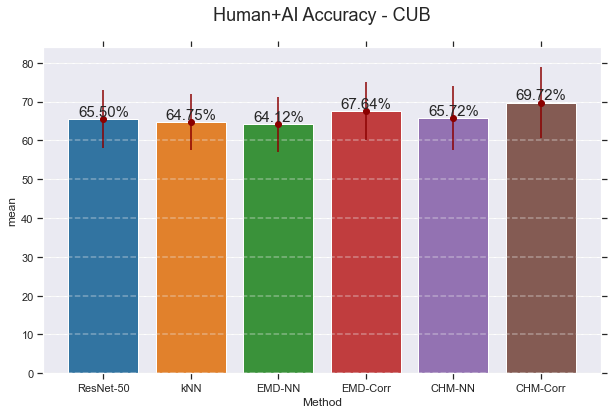

In [64]:
fig, ax = plt.subplots(1, figsize=(10, 6))

sns.barplot(data=accuracy_df, x='Method', y='mean', ax=ax, palette="tab10")

for container in ax.containers:
  ax.bar_label(container, fontsize=15, fmt='%.2f%%')
    
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

# Draw horizontal axis lines
vals = ax.get_yticks()
for tick in vals:
  ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

plt.title(f'Human+AI Accuracy - {DATA_SET}\n', fontsize=18)
plt.errorbar(accuracy_df['Method'], accuracy_df['mean'], yerr=accuracy_df['std'], fmt="o", color="darkred")
plt.show()

# Confusing and Easy samples for Human

## Confusing

In [65]:
tmp = df.groupby(['Query'])['Correctness'].agg(['mean', 'count']).reset_index().sort_values(['mean', 'count'], ascending=[True, False])
tmp = tmp[ (tmp['mean'] < 0.25)]  
confusing_queries = tmp.sort_values(['mean', 'count'], ascending=[True, False])['Query'].values

In [66]:
confusing_df = df[df['Query'].isin(confusing_queries)]

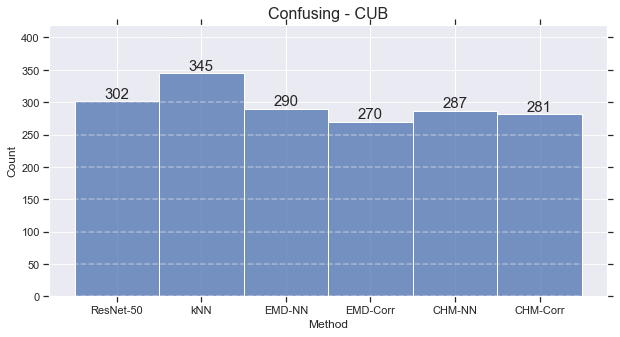

In [67]:
fig, ax = plt.subplots(1, figsize=(10,5))
sns.histplot(data=confusing_df, x='Method', ax=ax)

for container in ax.containers:
  ax.bar_label(container, fontsize=15)
    
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

# Draw horizontal axis lines
vals = ax.get_yticks()
for tick in vals:
  ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

plt.title(f'Confusing - {DATA_SET}', fontsize=16)
plt.show()

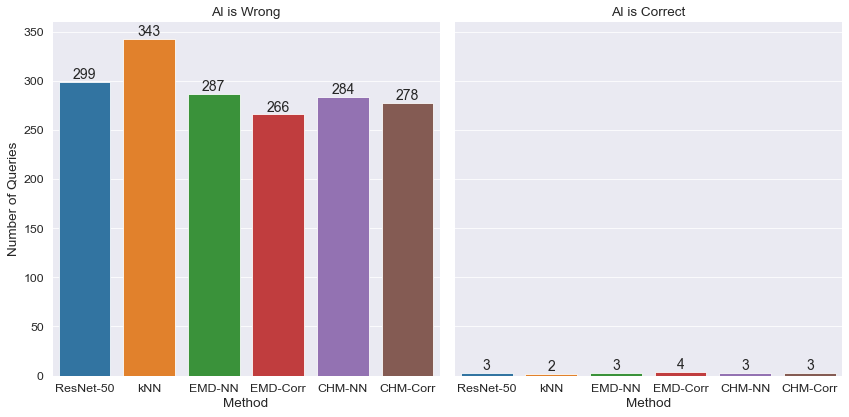

In [68]:
with sns.plotting_context('paper', font_scale = 1.4):
  g = sns.FacetGrid(confusing_df.groupby(['Method', 'ClassifierCorrectness'])['UID'].count().reset_index(), col="ClassifierCorrectness", height=6)
  g.map(sns.barplot, "Method", "UID", order=['ResNet-50', 'kNN', 'EMD-NN', 'EMD-Corr', 'CHM-NN', 'CHM-Corr'], palette="tab10")

  for ax in g.axes.flat:
    for container in ax.containers:
      ax.bar_label(container, fontsize=14)

  axes = g.axes.flatten()
  axes[0].set_title('AI is Wrong')
  axes[1].set_title('AI is Correct')
  axes[0].set_ylabel('Number of Queries')
  plt.savefig(f'../plots/human-study-main-results/CUB-ConfusingQueries.pdf', dpi=100, bbox_inches='tight')
  plt.show()

In [69]:
# Cleaning the labels (removing extra characters) the dirty way!

confusing_df['GroundTruth'] = confusing_df['GroundTruth'].apply(lambda x: ' '.join((x.replace('_', ' ').replace('.', ' ').title()).split(' ')[1:]))

confusing_df['ResNet-Prediction'] = confusing_df['ResNet-Prediction'].apply(lambda x: ' '.join((x.replace('_', ' ').replace('.', ' ').title()).split(' ')[1:]))
confusing_df['KNN-Prediction']    = confusing_df['KNN-Prediction'].apply(lambda x: ' '.join((x.replace('_', ' ').replace('.', ' ').title()).split(' ')[1:]))
confusing_df['EMD-Prediction']    = confusing_df['EMD-Prediction'].apply(lambda x: ' '.join((x.replace('_', ' ').replace('.', ' ').title()).split(' ')[1:]))
confusing_df['CHM-Prediction']    = confusing_df['CHM-Prediction'].apply(lambda x: ' '.join((x.replace('_', ' ').replace('.', ' ').title()).split(' ')[1:]))

/tmp/ipykernel_2122802/245100152.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confusing_df['GroundTruth'] = confusing_df['GroundTruth'].apply(lambda x: ' '.join((x.replace('_', ' ').replace('.', ' ').title()).split(' ')[1:]))
/tmp/ipykernel_2122802/245100152.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confusing_df['ResNet-Prediction'] = confusing_df['ResNet-Prediction'].apply(lambda x: ' '.join((x.replace('_', ' ').replace('.', ' ').title()).split(' ')[1:]))
/tmp/ipykernel_2122802/245100152.p

In [70]:
resnet_c = confusing_df[confusing_df['Method']=='ResNet-50']
resnet_confusion = resnet_c.groupby(['GroundTruth', 'ResNet-Prediction'])['UID'].count().to_frame().sort_values(by='UID', ascending=False).reset_index()

In [71]:
resnet_confusion.head(5)

,GroundTruth,ResNet-Prediction,UID
0,Forsters Tern,Common Tern,17
1,Great Grey Shrike,Loggerhead Shrike,10
2,Nelson Sharp Tailed Sparrow,Le Conte Sparrow,8
3,Acadian Flycatcher,Least Flycatcher,7
4,American Crow,Common Raven,7


In [72]:
knn_c = confusing_df[confusing_df['Method']=='kNN']
knn_confusion = knn_c.groupby(['GroundTruth', 'KNN-Prediction'])['UID'].count().to_frame().sort_values(by='UID', ascending=False).reset_index()

In [73]:
knn_confusion.head(5)

,GroundTruth,KNN-Prediction,UID
0,California Gull,Western Gull,21
1,Elegant Tern,Caspian Tern,13
2,Fish Crow,American Crow,12
3,Rusty Blackbird,Brewer Blackbird,11
4,Acadian Flycatcher,Yellow Bellied Flycatcher,10


In [74]:
emd_nns = confusing_df[confusing_df['Method']=='EMD-Corr']
emd_nn_confusion = emd_nns.groupby(['GroundTruth', 'EMD-Prediction'])['UID'].count().to_frame().sort_values(by='UID', ascending=False).reset_index()

In [75]:
emd_nn_confusion.head(5)

,GroundTruth,EMD-Prediction,UID
0,California Gull,Western Gull,15
1,Common Tern,Artic Tern,12
2,Nelson Sharp Tailed Sparrow,Savannah Sparrow,8
3,Acadian Flycatcher,Yellow Bellied Flycatcher,8
4,Yellow Bellied Flycatcher,Acadian Flycatcher,8


In [76]:
emd_corrs = confusing_df[confusing_df['Method']=='EMD-Corr']
emd_corr_confusion = emd_corrs.groupby(['GroundTruth', 'EMD-Prediction'])['UID'].count().to_frame().sort_values(by='UID', ascending=False).reset_index()

In [77]:
emd_corr_confusion.head(5)

,GroundTruth,EMD-Prediction,UID
0,California Gull,Western Gull,15
1,Common Tern,Artic Tern,12
2,Nelson Sharp Tailed Sparrow,Savannah Sparrow,8
3,Acadian Flycatcher,Yellow Bellied Flycatcher,8
4,Yellow Bellied Flycatcher,Acadian Flycatcher,8


In [78]:
chm_nns = confusing_df[confusing_df['Method']=='CHM-NN']
chm_nn_confusion = chm_nns.groupby(['GroundTruth', 'CHM-Prediction'])['UID'].count().to_frame().sort_values(by='UID', ascending=False).reset_index()

In [79]:
chm_nn_confusion.head(5)

,GroundTruth,CHM-Prediction,UID
0,Great Grey Shrike,Loggerhead Shrike,19
1,Le Conte Sparrow,Nelson Sharp Tailed Sparrow,15
2,California Gull,Western Gull,15
3,Louisiana Waterthrush,Northern Waterthrush,12
4,Horned Grebe,Eared Grebe,9


In [80]:
chm_corrs = confusing_df[confusing_df['Method']=='CHM-Corr']
chm_corr_confusion = chm_corrs.groupby(['GroundTruth', 'CHM-Prediction'])['UID'].count().to_frame().sort_values(by='UID', ascending=False).reset_index()

In [81]:
chm_corr_confusion.head(5)#.applymap(lambda x: str(x).replace('_', '').replace('.', '').title())

,GroundTruth,CHM-Prediction,UID
0,Great Grey Shrike,Loggerhead Shrike,20
1,Horned Grebe,Eared Grebe,15
2,California Gull,Western Gull,15
3,Louisiana Waterthrush,Northern Waterthrush,13
4,Le Conte Sparrow,Nelson Sharp Tailed Sparrow,13


In [82]:
confusing_df.groupby('GroundTruth')['UID'].count().reset_index().sort_values(by='UID', ascending=False).head(10)

,GroundTruth,UID
18,California Gull,112
36,Great Grey Shrike,66
26,Common Tern,59
31,Forsters Tern,52
52,Louisiana Waterthrush,50
0,Acadian Flycatcher,48
33,Glaucous Winged Gull,47
91,Western Wood Pewee,41
39,Herring Gull,41
30,Fish Crow,39


In [83]:
confusing_df.head(2)

,UID,Query,Counter balance,Validation Reaction Time,Test Reaction Time,Date,Correctness,Accuracy,Total Corrects,Method,GroundTruth,ClassifierCorrectness,ConfidenceScore,DifficultyLevel,ResNet-Prediction,KNN-Prediction,EMD-Prediction,CHM-Prediction,ResNet-Conf,KNN-Conf,EMD-Conf,CHM-Conf
1204,5cb329855ee1730001ae6683No-XAI,American_Crow_0048_25062.jpg,15,382592.0,381136,2022-05-06 01:09:16.104,0,0.533333,16,ResNet-50,American Crow,0,0.47,Medium,Common Raven,Common Raven,Common Raven,American Crow,0.47,0.025,0.025,0.0225
1199,60fd01e77185527745df543dNo-XAI,Canada_Warbler_0020_162354.jpg,1,418397.2,417151,2022-05-06 01:08:55.047,0,0.633333,19,ResNet-50,Canada Warbler,0,0.88,Hard,Nashville Warbler,Nashville Warbler,Nashville Warbler,Nashville Warbler,0.88,0.035,0.040,0.0325


# Method 2 vs Method 4

In [ ]:
all_gts  = {df['Query'].values[q]:df['GroundTruth'].values[q] for q in range(len(df))}
knn_pred = {df['Query'].values[q]:df['KNN-Prediction'].values[q] for q in range(len(df))}
chm_pred = {df['Query'].values[q]:df['CHM-Prediction'].values[q] for q in range(len(df))}

In [ ]:
gt__class = np.asarray([all_gts[q] for q in  df['Query'].values])
knn_class = np.asarray([knn_pred[q] for q in  df['Query'].values])
chm_class = np.asarray([chm_pred[q] for q in  df['Query'].values])

In [ ]:
df['KNN-Correctness'] = knn_class==gt__class
df['CHM-Correctness'] = chm_class==gt__class

### Groups

1. Corr users tend to better reject AI wrong decisions than others. Why? This example is a strong example for this trend. All 4/4 kNN users are fooled! And all 3/3 Corr users recognized the AI wrong decisions. Let’s make a full-page figure of examples like this ``(AI=wrong; kNN users = wrong; Corr users=correct)`` for this trend.
1. Corr users tend to reject AI correct decisions more. We should also make a full-page figure here ``(AI=correct; kNN users = correct; Corr users=wrong)``

In [ ]:
df_wrongs = df[(df['ClassifierCorrectness']==0) & (df['Method'].isin(['kNN', 'CHM-Corr']))]

In [ ]:
group1 = df_wrongs.groupby(['Query', 'Method'])['Correctness'].mean().unstack().dropna()
group1 = group1[(group1['kNN']==0.0) & (group1['CHM-Corr']==1.0)]

In [ ]:
df_correct = df[(df['ClassifierCorrectness']==1) & (df['Method'].isin(['CHM-Corr']))]

In [ ]:
group2 = df_correct.groupby(['Query', 'Method'])['Correctness'].mean().unstack().dropna()
group2 = group2[(group2['CHM-Corr']==0.0)]

In [ ]:
df_correct_emd = df[(df['ClassifierCorrectness']==1) & (df['Method'].isin(['EMD-Corr']))]
group2_emd = df_correct_emd.groupby(['Query', 'Method'])['Correctness'].mean().unstack().dropna()
group2_emd = group2_emd[(group2_emd['EMD-Corr']==0.0)]

### Other groups

In [ ]:
# shared KNN CHM-Corr
df_correct = df[(df['ClassifierCorrectness']==1) & (df['Method'].isin(['kNN', 'CHM-NN']))]
group_x = df_correct.groupby(['Query', 'Method'])['Correctness'].mean().unstack().dropna()
group_x

In [ ]:
# shared KNN EMD-Corr
df_correct = df[(df['ClassifierCorrectness']==1) & (df['Method'].isin(['kNN', 'EMD-NN']))]
group_y = df_correct.groupby(['Query', 'Method'])['Correctness'].mean().unstack().dropna()
group_y

# Plot Different Methods

In [ ]:
import torchvision.transforms as transforms
from PIL import Image
import json

display_transform  = transforms.Compose([transforms.Resize(256), transforms.CenterCrop((224, 224))])

In [ ]:
MethodKeyMapper = {
  'ResNet-50': 0,
  'kNN': 1,
  'EMD-NN':  2,
  'EMD-Corr': 2,
  'CHM-NN': 3,
  'CHM-Corr': 3
}

## ResNet vs Others

In [ ]:
VisualizationsKeyMapper = {
  'ResNet-50': 'HS_No_XAI',
  'kNN':      'HS_KNNs',
  'EMD-NN':    'HS_EMD_NNs',
  'EMD-Corr':  'HS_EMD_Corrs',
  'CHM-NN':    'HS_CHM_NNs',
  'CHM-Corr':  'HS_CHM_Corrs'
}

In [ ]:
Pairs = [['ResNet-50', 'kNN'], 
         ['ResNet-50', 'EMD-NN'],
         ['ResNet-50', 'EMD-Corr'], 
         ['ResNet-50', 'CHM-NN'],
         ['ResNet-50', 'CHM-Corr'],
        ]         

In [ ]:
df.groupby('Query')[['Query', 'Method', 'Correctness', 'ClassifierCorrectness']].filter(lambda x: True).head(2)

In [ ]:
def plot_queries(df_shared, pair):
  pp = PdfPages(f'../plots/is-xai-helping/{pair[0]}-vs-{pair[1]}.pdf')

  os.makedirs(f'../plots/is-xai-helping/{pair[0]}-vs-{pair[1]}/', exist_ok=True)
  
  for i, row in df_shared.groupby(['ClassifierCorrectness', 'Query', 'Method'])[['Correctness']].agg(['mean', 'count']).unstack().reset_index().dropna().iterrows():
    # print(row)
    fig, axes = plt.subplots(1, 3, figsize=(25, 5), gridspec_kw={'width_ratios': [0.01, 4, 16]}, facecolor=(1,1,1))
    axes[0].set_axis_off()
    axes[1].set_axis_off()
    axes[2].set_axis_off()

    q = row.reset_index()[i][1]
    
    real_gt = df.loc[df['Query'] == q].iloc[0]['GroundTruth']

    Method_Predictions = {}
    Method_Predictions[0] = df.loc[df['Query'] == q].iloc[0]['ResNet-Prediction']
    Method_Predictions[1] = df.loc[df['Query'] == q].iloc[0]['KNN-Prediction']
    Method_Predictions[2] = df.loc[df['Query'] == q].iloc[0]['EMD-Prediction']
    Method_Predictions[3] = df.loc[df['Query'] == q].iloc[0]['CHM-Prediction']

    Method_Confidences = {}
    Method_Confidences[0] = df.loc[df['Query'] == q].iloc[0]['ResNet-Conf']
    Method_Confidences[1] = df.loc[df['Query'] == q].iloc[0]['KNN-Conf']
    Method_Confidences[2] = df.loc[df['Query'] == q].iloc[0]['EMD-Conf']
    Method_Confidences[3] = df.loc[df['Query'] == q].iloc[0]['CHM-Conf']

    m1_count = row.reset_index()[i][5] 
    m1_mean  = row.reset_index()[i][3] 
    m2_count = row.reset_index()[i][4] 
    m2_mean  = row.reset_index()[i][2] 

    m1_name = row['Correctness'].reset_index()['Method'][1]
    m2_name = row['Correctness'].reset_index()['Method'][0]


    m1_color = 'yellow'
    m2_color = 'yellow'

    if m1_mean>m2_mean:
      m1_color = 'green'
      m2_color = 'red'
    elif  m1_mean<m2_mean:
      m1_color = 'red'
      m2_color = 'green'
    else:
      m1_color = 'green'
      m2_color = 'green'

    axes[1].text(0, 0.9, f"{m1_name} Users: {int(m1_count)}" ,fontsize=16)
    axes[1].text(0, 0.8, f"{m2_name} Users: {int(m2_count)}" ,fontsize=16)
    axes[1].text(0, 0.6, f"{m1_name} Human Accuracy: {100*m1_mean:.1f}%" ,fontsize=16, color=m1_color)
    axes[1].text(0, 0.5, f"{m2_name} Human Accuracy: {100*m2_mean:.1f}%" ,fontsize=16, color=m2_color)
    axes[1].text(0, 0.05, f"Ground Truth: {real_gt}" ,fontsize=16, color='blue')

    m1_pred = Method_Predictions[MethodKeyMapper[m1_name]]
    m1_conf = Method_Confidences[MethodKeyMapper[m1_name]]

    m2_pred = Method_Predictions[MethodKeyMapper[m2_name]]
    m2_conf = Method_Confidences[MethodKeyMapper[m2_name]]

    m1_color = 'black'
    if m1_pred == real_gt:
      m1_color = 'green'
    else:
      m1_color = 'red'

    m2_color = 'black'
    if m2_pred == real_gt:
      m2_color = 'green'
    else:
      m2_color = 'red'

    axes[1].text(0, 0.3, f"{m1_name} output: {m1_pred.replace('_', ' ').title()}" ,fontsize=18, color=m1_color)
    axes[1].text(0, 0.2, f"{m2_name} output: {m2_pred.replace('_', ' ').title()}" ,fontsize=18, color=m2_color)

    # axes[0].imshow(Image.open(f'/mnt/NeurIPS/supporting_files/{VisualizationsKeyMapper[m1_name]}/{q}'))
    axes[2].imshow(Image.open(f'/mnt/NeurIPS/supporting_files/{VisualizationsKeyMapper[pair[1]]}/{q}'))
    fig.savefig(f'../plots/is-xai-helping/{pair[0]}-vs-{pair[1]}/{i}.pdf' ,dpi=100, bbox_inches='tight')
    pp.savefig(fig)
    plt.close()

  pp.close()

In [ ]:
for method_pair in tqdm(Pairs):
  common_qs = df[df.Method.isin(method_pair)].groupby(['Query', 'Method'])[['Correctness']].count().unstack().dropna().stack().reset_index()['Query']
  df_shared = df[(df['Query'].isin(common_qs)) & df.Method.isin(method_pair)]
  plot_queries(df_shared, method_pair)

## kNN vs Other NNs

In [ ]:
VisualizationsKeyMapper = {
  'ResNet-50': 'HS_No_XAI',
  'kNN':      'HS_KNNs',
  'EMD-NN':    'HS_EMD_NNs',
  'EMD-Corr':  'HS_EMD_Corrs',
  'CHM-NN':    'HS_CHM_NNs',
  'CHM-Corr':  'HS_CHM_Corrs'
}

In [ ]:
Pairs = [['kNN', 'EMD-NN'],
         ['kNN', 'CHM-NN']]         

In [ ]:
df.groupby('Query')[['Query', 'Method', 'Correctness', 'ClassifierCorrectness']].filter(lambda x: True).head(2)

In [ ]:
def plot_parents(data, pair):
  fig, ax = plt.subplots(1, figsize=(12,5))
  sns.histplot(data=data, x='Parent-lvl12', ax=ax)

  for container in ax.containers:
    ax.bar_label(container, fontsize=15)

  ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

  # Draw horizontal axis lines
  vals = ax.get_yticks()
  for tick in vals:
    ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

  plt.title(pair)
  plt.show()

In [ ]:
def plot_queries(df_shared, pair):
  pp = PdfPages(f'../plots/is-xai-helping/{pair[0]}-vs-{pair[1]}.pdf')
  os.makedirs(f'../plots/is-xai-helping/{pair[0]}-vs-{pair[1]}/', exist_ok=True)
  for i, row in df_shared.groupby(['ClassifierCorrectness', 'Query', 'Method'])[['Correctness']].agg(['mean', 'count']).unstack().reset_index().dropna().iterrows():
  
    fig, axes = plt.subplots(2, 2, figsize=(25, 10), gridspec_kw={'width_ratios': [5, 15]}, facecolor=(1,1,1))

    ax0 = axes[0][0]
    ax1 = axes[1][0]
    ax2 = axes[0][1]
    ax3 = axes[1][1]

    for T in range(2):
      for K in range(2):
        axes[T][K].set_axis_off()

    q = row.reset_index()[i][1]
    real_gt = df.loc[df['Query'] == q].iloc[0]['GroundTruth']
    
    Method_Predictions = {}
    Method_Predictions[0] = df.loc[df['Query'] == q].iloc[0]['ResNet-Prediction']
    Method_Predictions[1] = df.loc[df['Query'] == q].iloc[0]['KNN-Prediction']
    Method_Predictions[2] = df.loc[df['Query'] == q].iloc[0]['EMD-Prediction']
    Method_Predictions[3] = df.loc[df['Query'] == q].iloc[0]['CHM-Prediction']

    Method_Confidences = {}
    Method_Confidences[0] = df.loc[df['Query'] == q].iloc[0]['ResNet-Conf']
    Method_Confidences[1] = df.loc[df['Query'] == q].iloc[0]['KNN-Conf']
    Method_Confidences[2] = df.loc[df['Query'] == q].iloc[0]['EMD-Conf']
    Method_Confidences[3] = df.loc[df['Query'] == q].iloc[0]['CHM-Conf']

    m1_count = row.reset_index()[i][5] 
    m1_mean  = row.reset_index()[i][3] 
    m2_count = row.reset_index()[i][4] 
    m2_mean  = row.reset_index()[i][2] 

    m1_name = row['Correctness'].reset_index()['Method'][1]
    m2_name = row['Correctness'].reset_index()['Method'][0]

    m1_color = 'yellow'
    m2_color = 'yellow'

    if m1_mean>m2_mean:
      m1_color = 'green'
      m2_color = 'red'
    elif  m1_mean<m2_mean:
      m1_color = 'red'
      m2_color = 'green'
    else:
      m1_color = 'green'
      m2_color = 'green'

    ax1.text(0.15, 0.9, f"{m1_name} Users: {int(m1_count)}" ,fontsize=16)
    ax1.text(0.15, 0.8, f"{m2_name} Users: {int(m2_count)}" ,fontsize=16)
    ax1.text(0.15, 0.6, f"{m1_name} Human Accuracy: {100*m1_mean:.1f}%" ,fontsize=16, color=m1_color)
    ax1.text(0.15, 0.5, f"{m2_name} Human Accuracy: {100*m2_mean:.1f}%" ,fontsize=16, color=m2_color)
    ax1.text(0.15, 0.05, f"Ground Truth: {real_gt}" ,fontsize=16, color='blue')

    m1_pred = Method_Predictions[MethodKeyMapper[m1_name]]
    m1_conf = Method_Confidences[MethodKeyMapper[m1_name]]

    m2_pred = Method_Predictions[MethodKeyMapper[m2_name]]
    m2_conf = Method_Confidences[MethodKeyMapper[m2_name]]

    m1_color = 'black'
    if m1_pred == real_gt:
      m1_color = 'green'
    else:
      m1_color = 'red'

    m2_color = 'black'
    if m2_pred == real_gt:
      m2_color = 'green'
    else:
      m2_color = 'red'

    ax1.text(0.15, 0.3, f"{m1_name} output: {m1_pred.replace('_', ' ').title()}" ,fontsize=18, color=m1_color)
    ax1.text(0.15, 0.2, f"{m2_name} output: {m2_pred.replace('_', ' ').title()}" ,fontsize=18, color=m2_color)

    ax2.set_title(m1_name, fontsize=15)
    ax2.imshow(load_part_of_image(f'/mnt/NeurIPS/supporting_files/{VisualizationsKeyMapper[m1_name]}/{q}', 510,0,0,0))
    ax3.set_title(m2_name, fontsize=15)
    ax3.imshow(load_part_of_image(f'/mnt/NeurIPS/supporting_files/{VisualizationsKeyMapper[m2_name]}/{q}', 510,0,0,0))

    ax0.set_title('Query', fontsize=15)
    ax0.imshow(load_part_of_image(f'/mnt/NeurIPS/supporting_files/{VisualizationsKeyMapper[m1_name]}/{q}', 0,0,2125,0))
    plt.subplots_adjust(wspace=0, hspace=0)
    fig.savefig(f'../plots/is-xai-helping/{pair[0]}-vs-{pair[1]}/{i}.pdf' ,dpi=100, bbox_inches='tight')
    pp.savefig(fig)
    plt.close()
  
  pp.close()

In [ ]:
for method_pair in tqdm(Pairs):
  common_qs = df[df.Method.isin(method_pair)].groupby(['Query', 'Method'])[['Correctness']].count().unstack().dropna().stack().reset_index()['Query']
  df_shared = df[(df['Query'].isin(common_qs)) & df.Method.isin(method_pair)]
  plot_queries(df_shared, method_pair)

## EMD Corrs vs CHM Corrs

In [ ]:
Pairs = [['EMD-Corr', 'CHM-Corr']]         

In [ ]:
df.groupby('Query')[['Query', 'Method', 'Correctness', 'ClassifierCorrectness']].filter(lambda x: True).head(2)

In [ ]:
def plot_parents(data, pair):
  fig, ax = plt.subplots(1, figsize=(12,5))
  sns.histplot(data=data, x='Parent-lvl12', ax=ax)

  for container in ax.containers:
    ax.bar_label(container, fontsize=15)

  ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

  # Draw horizontal axis lines
  vals = ax.get_yticks()
  for tick in vals:
    ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

  plt.title(pair)
  plt.show()

In [ ]:
def plot_queries(df_shared, pair):
  pp = PdfPages(f'../plots/is-xai-helping/{pair[0]}-vs-{pair[1]}.pdf')
  os.makedirs(f'../plots/is-xai-helping/{pair[0]}-vs-{pair[1]}/', exist_ok=True)
  for i, row in df_shared.groupby(['ClassifierCorrectness', 'Query', 'Method'])[['Correctness']].agg(['mean', 'count']).unstack().reset_index().dropna().iterrows():
  
    fig, axes = plt.subplots(2, 2, figsize=(25, 15), gridspec_kw={'width_ratios': [5, 30]}, facecolor=(1,1,1))

    ax0 = axes[0][0]
    ax1 = axes[1][0]
    ax2 = axes[0][1]
    ax3 = axes[1][1]

    for T in range(2):
      for K in range(2):
        axes[T][K].set_axis_off()

    q = row.reset_index()[i][1]
    real_gt = df.loc[df['Query'] == q].iloc[0]['GroundTruth']

    Method_Predictions = {}
    Method_Predictions[0] = df.loc[df['Query'] == q].iloc[0]['ResNet-Prediction']
    Method_Predictions[1] = df.loc[df['Query'] == q].iloc[0]['KNN-Prediction']
    Method_Predictions[2] = df.loc[df['Query'] == q].iloc[0]['EMD-Prediction']
    Method_Predictions[3] = df.loc[df['Query'] == q].iloc[0]['CHM-Prediction']

    Method_Confidences = {}
    Method_Confidences[0] = df.loc[df['Query'] == q].iloc[0]['ResNet-Conf']
    Method_Confidences[1] = df.loc[df['Query'] == q].iloc[0]['KNN-Conf']
    Method_Confidences[2] = df.loc[df['Query'] == q].iloc[0]['EMD-Conf']
    Method_Confidences[3] = df.loc[df['Query'] == q].iloc[0]['CHM-Conf']

    m1_count = row.reset_index()[i][5] 
    m1_mean  = row.reset_index()[i][3] 
    m2_count = row.reset_index()[i][4] 
    m2_mean  = row.reset_index()[i][2] 

    m1_name = row['Correctness'].reset_index()['Method'][1]
    m2_name = row['Correctness'].reset_index()['Method'][0]


    m1_color = 'yellow'
    m2_color = 'yellow'

    if m1_mean>m2_mean:
      m1_color = 'green'
      m2_color = 'red'
    elif  m1_mean<m2_mean:
      m1_color = 'red'
      m2_color = 'green'
    else:
      m1_color = 'green'
      m2_color = 'green'

    ax1.text(0.05, 0.9, f"{m1_name} Users: {int(m1_count)}" ,fontsize=16)
    ax1.text(0.05, 0.8, f"{m2_name} Users: {int(m2_count)}" ,fontsize=16)
    ax1.text(0.05, 0.6, f"{m1_name} Human Accuracy: {100*m1_mean:.1f}%" ,fontsize=16, color=m1_color)
    ax1.text(0.05, 0.5, f"{m2_name} Human Accuracy: {100*m2_mean:.1f}%" ,fontsize=16, color=m2_color)
    ax1.text(0.15, 0.05, f"Ground Truth: {real_gt}" ,fontsize=16, color='blue')

    m1_pred = Method_Predictions[MethodKeyMapper[m1_name]]
    m1_conf = Method_Confidences[MethodKeyMapper[m1_name]]

    m2_pred = Method_Predictions[MethodKeyMapper[m2_name]]
    m2_conf = Method_Confidences[MethodKeyMapper[m2_name]]

    m1_color = 'black'
    if m1_pred == real_gt:
      m1_color = 'green'
    else:
      m1_color = 'red'

    m2_color = 'black'
    if m2_pred == real_gt:
      m2_color = 'green'
    else:
      m2_color = 'red'

    ax1.text(0.05, 0.3, f"{m1_name} output: {m1_pred.replace('_', ' ').title()}" ,fontsize=18, color=m1_color)
    ax1.text(0.05, 0.2, f"{m2_name} output: {m2_pred.replace('_', ' ').title()}" ,fontsize=18, color=m2_color)

    ax2.set_title(m1_name, fontsize=15)
    ax2.imshow(load_part_of_image(f'/mnt/NeurIPS/supporting_files/{VisualizationsKeyMapper[m1_name]}/{q}', 510,0,0,0))
    ax3.set_title(m2_name, fontsize=15)
    ax3.imshow(load_part_of_image(f'/mnt/NeurIPS/supporting_files/{VisualizationsKeyMapper[m2_name]}/{q}', 510,0,0,0))
    ax0.set_title('Query', fontsize=15)
    ax0.imshow(load_part_of_image(f'/mnt/NeurIPS/supporting_files/{VisualizationsKeyMapper[m1_name]}/{q}', 0,0,2150,400))

    plt.subplots_adjust(wspace=0.025, hspace=0.1)
    
    fig.savefig(f'../plots/is-xai-helping/{pair[0]}-vs-{pair[1]}/{i}.pdf' ,dpi=100, bbox_inches='tight')
    pp.savefig(fig)
    plt.close()
  
  pp.close()

In [ ]:
for method_pair in tqdm(Pairs):
  common_qs = df[df.Method.isin(method_pair)].groupby(['Query', 'Method'])[['Correctness']].count().unstack().dropna().stack().reset_index()['Query']
  df_shared = df[(df['Query'].isin(common_qs)) & df.Method.isin(method_pair)]
  plot_queries(df_shared, method_pair)

## NNs vs Corrs vs Corrs

In [ ]:
Pairs = [['kNN', 'EMD-Corr'],
         ['kNN', 'CHM-Corr']]         

In [ ]:
df.groupby('Query')[['Query', 'Method', 'Correctness', 'ClassifierCorrectness']].filter(lambda x: True).head(2)

In [ ]:
def plot_parents(data, pair):
  fig, ax = plt.subplots(1, figsize=(12,5))
  sns.histplot(data=data, x='Parent-lvl12', ax=ax)

  for container in ax.containers:
    ax.bar_label(container, fontsize=15)

  ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

  # Draw horizontal axis lines
  vals = ax.get_yticks()
  for tick in vals:
    ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

  plt.title(pair)
  plt.show()

In [ ]:
def plot_queries(df_shared, pair):
  pp = PdfPages(f'../plots/is-xai-helping/{pair[0]}-vs-{pair[1]}.pdf')
  os.makedirs(f'../plots/is-xai-helping/{pair[0]}-vs-{pair[1]}/', exist_ok=True)
  for i, row in df_shared.groupby(['ClassifierCorrectness', 'Query', 'Method'])[['Correctness']].agg(['mean', 'count']).unstack().reset_index().dropna().iterrows():
  
    fig, axes = plt.subplots(2, 2, figsize=(25, 10), gridspec_kw={'width_ratios': [5, 15],'height_ratios': [1,1.95]}, facecolor=(1,1,1))

    ax0 = axes[0][0]
    ax1 = axes[1][0]
    ax2 = axes[0][1]
    ax3 = axes[1][1]

    for T in range(2):
      for K in range(2):
        axes[T][K].set_axis_off()

    q = row.reset_index()[i][1]
    real_gt = df.loc[df['Query'] == q].iloc[0]['GroundTruth']

    Method_Predictions = {}
    Method_Predictions[0] = df.loc[df['Query'] == q].iloc[0]['ResNet-Prediction']
    Method_Predictions[1] = df.loc[df['Query'] == q].iloc[0]['KNN-Prediction']
    Method_Predictions[2] = df.loc[df['Query'] == q].iloc[0]['EMD-Prediction']
    Method_Predictions[3] = df.loc[df['Query'] == q].iloc[0]['CHM-Prediction']

    Method_Confidences = {}
    Method_Confidences[0] = df.loc[df['Query'] == q].iloc[0]['ResNet-Conf']
    Method_Confidences[1] = df.loc[df['Query'] == q].iloc[0]['KNN-Conf']
    Method_Confidences[2] = df.loc[df['Query'] == q].iloc[0]['EMD-Conf']
    Method_Confidences[3] = df.loc[df['Query'] == q].iloc[0]['CHM-Conf']

    m1_count = row.reset_index()[i][5] 
    m1_mean  = row.reset_index()[i][3] 
    m2_count = row.reset_index()[i][4] 
    m2_mean  = row.reset_index()[i][2] 

    m1_name = row['Correctness'].reset_index()['Method'][1]
    m2_name = row['Correctness'].reset_index()['Method'][0]

    m1_color = 'yellow'
    m2_color = 'yellow'

    if m1_mean>m2_mean:
      m1_color = 'green'
      m2_color = 'red'
    elif  m1_mean<m2_mean:
      m1_color = 'red'
      m2_color = 'green'
    else:
      m1_color = 'green'
      m2_color = 'green'

    ax1.text(0.25, 0.9, f"{m1_name} Users: {int(m1_count)}" ,fontsize=16)
    ax1.text(0.25, 0.8, f"{m2_name} Users: {int(m2_count)}" ,fontsize=16)
    ax1.text(0.25, 0.6, f"{m1_name} Human Accuracy: {100*m1_mean:.1f}%" ,fontsize=16, color=m1_color)
    ax1.text(0.25, 0.5, f"{m2_name} Human Accuracy: {100*m2_mean:.1f}%" ,fontsize=16, color=m2_color)
    ax1.text(0.15, 0.05, f"Ground Truth: {real_gt}" ,fontsize=16, color='blue')

    m1_pred = Method_Predictions[MethodKeyMapper[m1_name]]
    m1_conf = Method_Confidences[MethodKeyMapper[m1_name]]

    m2_pred = Method_Predictions[MethodKeyMapper[m2_name]]
    m2_conf = Method_Confidences[MethodKeyMapper[m2_name]]

    m1_color = 'black'
    if m1_pred == real_gt:
      m1_color = 'green'
    else:
      m1_color = 'red'

    m2_color = 'black'
    if m2_pred == real_gt:
      m2_color = 'green'
    else:
      m2_color = 'red'

    ax1.text(0.25, 0.3, f"{m1_name} output: {m1_pred.replace('_', ' ').title()}" ,fontsize=18, color=m1_color)
    ax1.text(0.25, 0.2, f"{m2_name} output: {m2_pred.replace('_', ' ').title()}" ,fontsize=18, color=m2_color)

    ax2.set_title(m1_name, fontsize=15)
    ax2.imshow(load_part_of_image(f'/mnt/NeurIPS/supporting_files/{VisualizationsKeyMapper[m1_name]}/{q}', 510,0,0,0))
    ax3.set_title(m2_name, fontsize=15)
    ax3.imshow(load_part_of_image(f'/mnt/NeurIPS/supporting_files/{VisualizationsKeyMapper[m2_name]}/{q}', 510,0,0,0))
    ax0.set_title('Query', fontsize=15)
    ax0.imshow(load_part_of_image(f'/mnt/NeurIPS/supporting_files/{VisualizationsKeyMapper[m2_name]}/{q}', 0,0,2150,400))

    plt.subplots_adjust(wspace=0.0, hspace=0.125)
    
    fig.savefig(f'../plots/is-xai-helping/{pair[0]}-vs-{pair[1]}/{i}.pdf' ,dpi=100, bbox_inches='tight')
    pp.savefig(fig)
    plt.close()
    # break
    
  pp.close()

In [ ]:
for method_pair in tqdm(Pairs):
  common_qs = df[df.Method.isin(method_pair)].groupby(['Query', 'Method'])[['Correctness']].count().unstack().dropna().stack().reset_index()['Query']
  df_shared = df[(df['Query'].isin(common_qs)) & df.Method.isin(method_pair)]
  plot_queries(df_shared, method_pair)

## Group 1

In [ ]:
Pairs = [['kNN', 'CHM-Corr']]         

In [ ]:
df.groupby('Query')[['Query', 'Method', 'Correctness', 'ClassifierCorrectness']].filter(lambda x: True).head(2)

In [ ]:
def plot_queries(df_shared, pair):
  os.makedirs(f'../plots/is-xai-helping/group1/{pair[0]}-vs-{pair[1]}/', exist_ok=True)
  pp = PdfPages(f'../plots/is-xai-helping/group1/{pair[0]}-vs-{pair[1]}.pdf')
  for i, row in df_shared.groupby(['ClassifierCorrectness', 'Query', 'Method'])[['Correctness']].agg(['mean', 'count']).unstack().reset_index().dropna().iterrows():
    fig, axes = plt.subplots(2, 2, figsize=(25, 10), gridspec_kw={'width_ratios': [5, 15],'height_ratios': [1,1.95]}, facecolor=(1,1,1))

    ax0 = axes[0][0]
    ax1 = axes[1][0]
    ax2 = axes[0][1]
    ax3 = axes[1][1]

    for T in range(2):
      for K in range(2):
        axes[T][K].set_axis_off()

    q = row.reset_index()[i][1]
    real_gt = df.loc[df['Query'] == q].iloc[0]['GroundTruth']

    Method_Predictions = {}
    Method_Predictions[0] = df.loc[df['Query'] == q].iloc[0]['ResNet-Prediction']
    Method_Predictions[1] = df.loc[df['Query'] == q].iloc[0]['KNN-Prediction']
    Method_Predictions[2] = df.loc[df['Query'] == q].iloc[0]['EMD-Prediction']
    Method_Predictions[3] = df.loc[df['Query'] == q].iloc[0]['CHM-Prediction']

    Method_Confidences = {}
    Method_Confidences[0] = df.loc[df['Query'] == q].iloc[0]['ResNet-Conf']
    Method_Confidences[1] = df.loc[df['Query'] == q].iloc[0]['KNN-Conf']
    Method_Confidences[2] = df.loc[df['Query'] == q].iloc[0]['EMD-Conf']
    Method_Confidences[3] = df.loc[df['Query'] == q].iloc[0]['CHM-Conf']

    m1_count = row.reset_index()[i][5] 
    m1_mean  = row.reset_index()[i][3] 
    m2_count = row.reset_index()[i][4] 
    m2_mean  = row.reset_index()[i][2] 

    m1_name = row['Correctness'].reset_index()['Method'][1]
    m2_name = row['Correctness'].reset_index()['Method'][0]


    m1_color = 'yellow'
    m2_color = 'yellow'

    if m1_mean>m2_mean:
      m1_color = 'green'
      m2_color = 'red'
    elif  m1_mean<m2_mean:
      m1_color = 'red'
      m2_color = 'green'
    else:
      m1_color = 'green'
      m2_color = 'green'

    ax1.text(0.25, 0.95, f"{m1_name} Users: {int(m1_count)}" ,fontsize=16)
    ax1.text(0.25, 0.85, f"{m2_name} Users: {int(m2_count)}" ,fontsize=16)
    ax1.text(0.25, 0.7, f"{m1_name} Human Accuracy: {100*m1_mean:.1f}%" ,fontsize=16, color=m1_color)
    ax1.text(0.25, 0.6, f"{m2_name} Human Accuracy: {100*m2_mean:.1f}%" ,fontsize=16, color=m2_color, fontweight="bold")
    ax1.text(0.25, 0.1, f"Ground Truth:\n {real_gt.split('.')[1].replace('_', ' ').title()}" ,fontsize=16, color='blue')

    m1_pred = Method_Predictions[MethodKeyMapper[m1_name]]
    m1_conf = Method_Confidences[MethodKeyMapper[m1_name]]

    m2_pred = Method_Predictions[MethodKeyMapper[m2_name]]
    m2_conf = Method_Confidences[MethodKeyMapper[m2_name]]

    m1_color = 'black'
    if m1_pred == real_gt:
      m1_color = 'green'
    else:
      m1_color = 'red'

    m2_color = 'black'
    if m2_pred == real_gt:
      m2_color = 'green'
    else:
      m2_color = 'red'

    ax1.text(0.25, 0.4, f"{m1_name} output:\n{m1_pred.split('.')[1].replace('_', ' ').title()}" ,fontsize=16, color=m1_color)
    ax1.text(0.25, 0.25, f"{m2_name} output:\n{m2_pred.split('.')[1].replace('_', ' ').title()}" ,fontsize=16, color=m2_color)

    ax2.set_title(m1_name, fontsize=15)
    ax2.imshow(load_part_of_image(f'/mnt/NeurIPS/supporting_files/{VisualizationsKeyMapper[m1_name]}/{q}', 510,0,0,0))
    ax3.set_title(m2_name, fontsize=15)
    ax3.imshow(load_part_of_image(f'/mnt/NeurIPS/supporting_files/{VisualizationsKeyMapper[m2_name]}/{q}', 510,0,0,0))
    ax0.set_title('Query', fontsize=15)
    ax0.imshow(load_part_of_image(f'/mnt/NeurIPS/supporting_files/{VisualizationsKeyMapper[m2_name]}/{q}', 0,0,2150,400))

    plt.subplots_adjust(wspace=0.0, hspace=0.125)
    
    fig.savefig(f'../plots/is-xai-helping/group1/{pair[0]}-vs-{pair[1]}/{i}.pdf' ,dpi=100, bbox_inches='tight')
    pp.savefig(fig)
    # plt.show()
    # break
    plt.close()
    
  pp.close()

In [ ]:
for method_pair in tqdm(Pairs):
  common_qs = df[df.Method.isin(method_pair)].groupby(['Query', 'Method'])[['Correctness']].count().unstack().dropna().stack().reset_index()['Query']
  df_shared = df[(df['Query'].isin(common_qs)) & df.Method.isin(method_pair)]
  # GROUP 1 Filtering
  df_shared = df_shared[df['Query'].isin(group1.index.values)]
  plot_queries(df_shared, method_pair)

## Group 2 (CHM)

In [ ]:
df_group2 = df[(df.Query.isin(group2.index))&(df.Method.isin(['CHM-Corr']))]

In [ ]:
ch_predictions = {x[0]:x[1] for x in df_group2[['Query', 'CHM-Prediction']].values}

In [ ]:
ch_predictions

In [ ]:
pp = PdfPages(f'../plots/is-xai-helping/group2/Group2.pdf')

for i, row in df_group2.groupby('Query')['UID'].count().reset_index().iterrows():
  q = row[0]
  c = row[1]

  fig, axes = plt.subplots(1, 2, figsize=(25,5), facecolor=(1,1,1), gridspec_kw={'width_ratios': [4, 16]})
  
  ax1, ax2 = axes
  ax1.set_axis_off()
  ax2.set_axis_off()
  ax2.imshow(load_part_of_image(f'/mnt/NeurIPS/supporting_files/HS_CHM_Corrs/{q}', 0,0,0,0))
  ax2.set_axis_off()
  
  
  ax1.text(0.25, 0.9, f"Query: {q.replace('.jpg', '')}" ,fontsize=16)
  ax1.text(0.25, 0.8, f"CHM Prediction: {ch_predictions[q].split('.')[1].replace('_', ' ').title()}" ,fontsize=16, color='green')
  ax1.text(0.25, 0.7, f"Users: {c}" ,fontsize=16)
  ax1.text(0.25, 0.6, f"Accuracy: {0}" ,fontsize=16, color='red')
  fig.savefig(f'../plots/is-xai-helping/group2/{i}.pdf' ,dpi=100, bbox_inches='tight')
  pp.savefig(fig)
  plt.show()

pp.close()

## Group 2 (EMD)

In [ ]:
df_group2 = df[(df.Query.isin(group2_emd.index))&(df.Method.isin(['EMD-Corr']))]

In [ ]:
EMD_predictions = {x[0]:x[1] for x in df_group2[['Query', 'EMD-Prediction']].values}

In [ ]:
EMD_predictions

In [ ]:
pp = PdfPages(f'../plots/is-xai-helping/group2-emd/Group2EMD.pdf')

for i, row in df_group2.groupby('Query')['UID'].count().reset_index().iterrows():
  q = row[0]
  c = row[1]

  fig, axes = plt.subplots(1, 2, figsize=(25,5), facecolor=(1,1,1), gridspec_kw={'width_ratios': [4, 16]})
  
  ax1, ax2 = axes
  ax1.set_axis_off()
  ax2.set_axis_off()
  ax2.imshow(load_part_of_image(f'/mnt/NeurIPS/supporting_files/HS_EMD_Corrs/{q}', 0,0,0,0))
  ax2.set_axis_off()
  
  
  ax1.text(0.25, 0.9, f"Query: {q.replace('.jpg', '')}" ,fontsize=16)
  ax1.text(0.25, 0.8, f"EMD Prediction: {EMD_predictions[q]}" ,fontsize=16, color='green')
  ax1.text(0.25, 0.7, f"Users: {c}" ,fontsize=16)
  ax1.text(0.25, 0.6, f"Accuracy: {0}" ,fontsize=16, color='red')
  fig.savefig(f'../plots/is-xai-helping/group2-emd/{i}.pdf' ,dpi=100, bbox_inches='tight')
  pp.savefig(fig)
  plt.show()

pp.close()